# Transformers

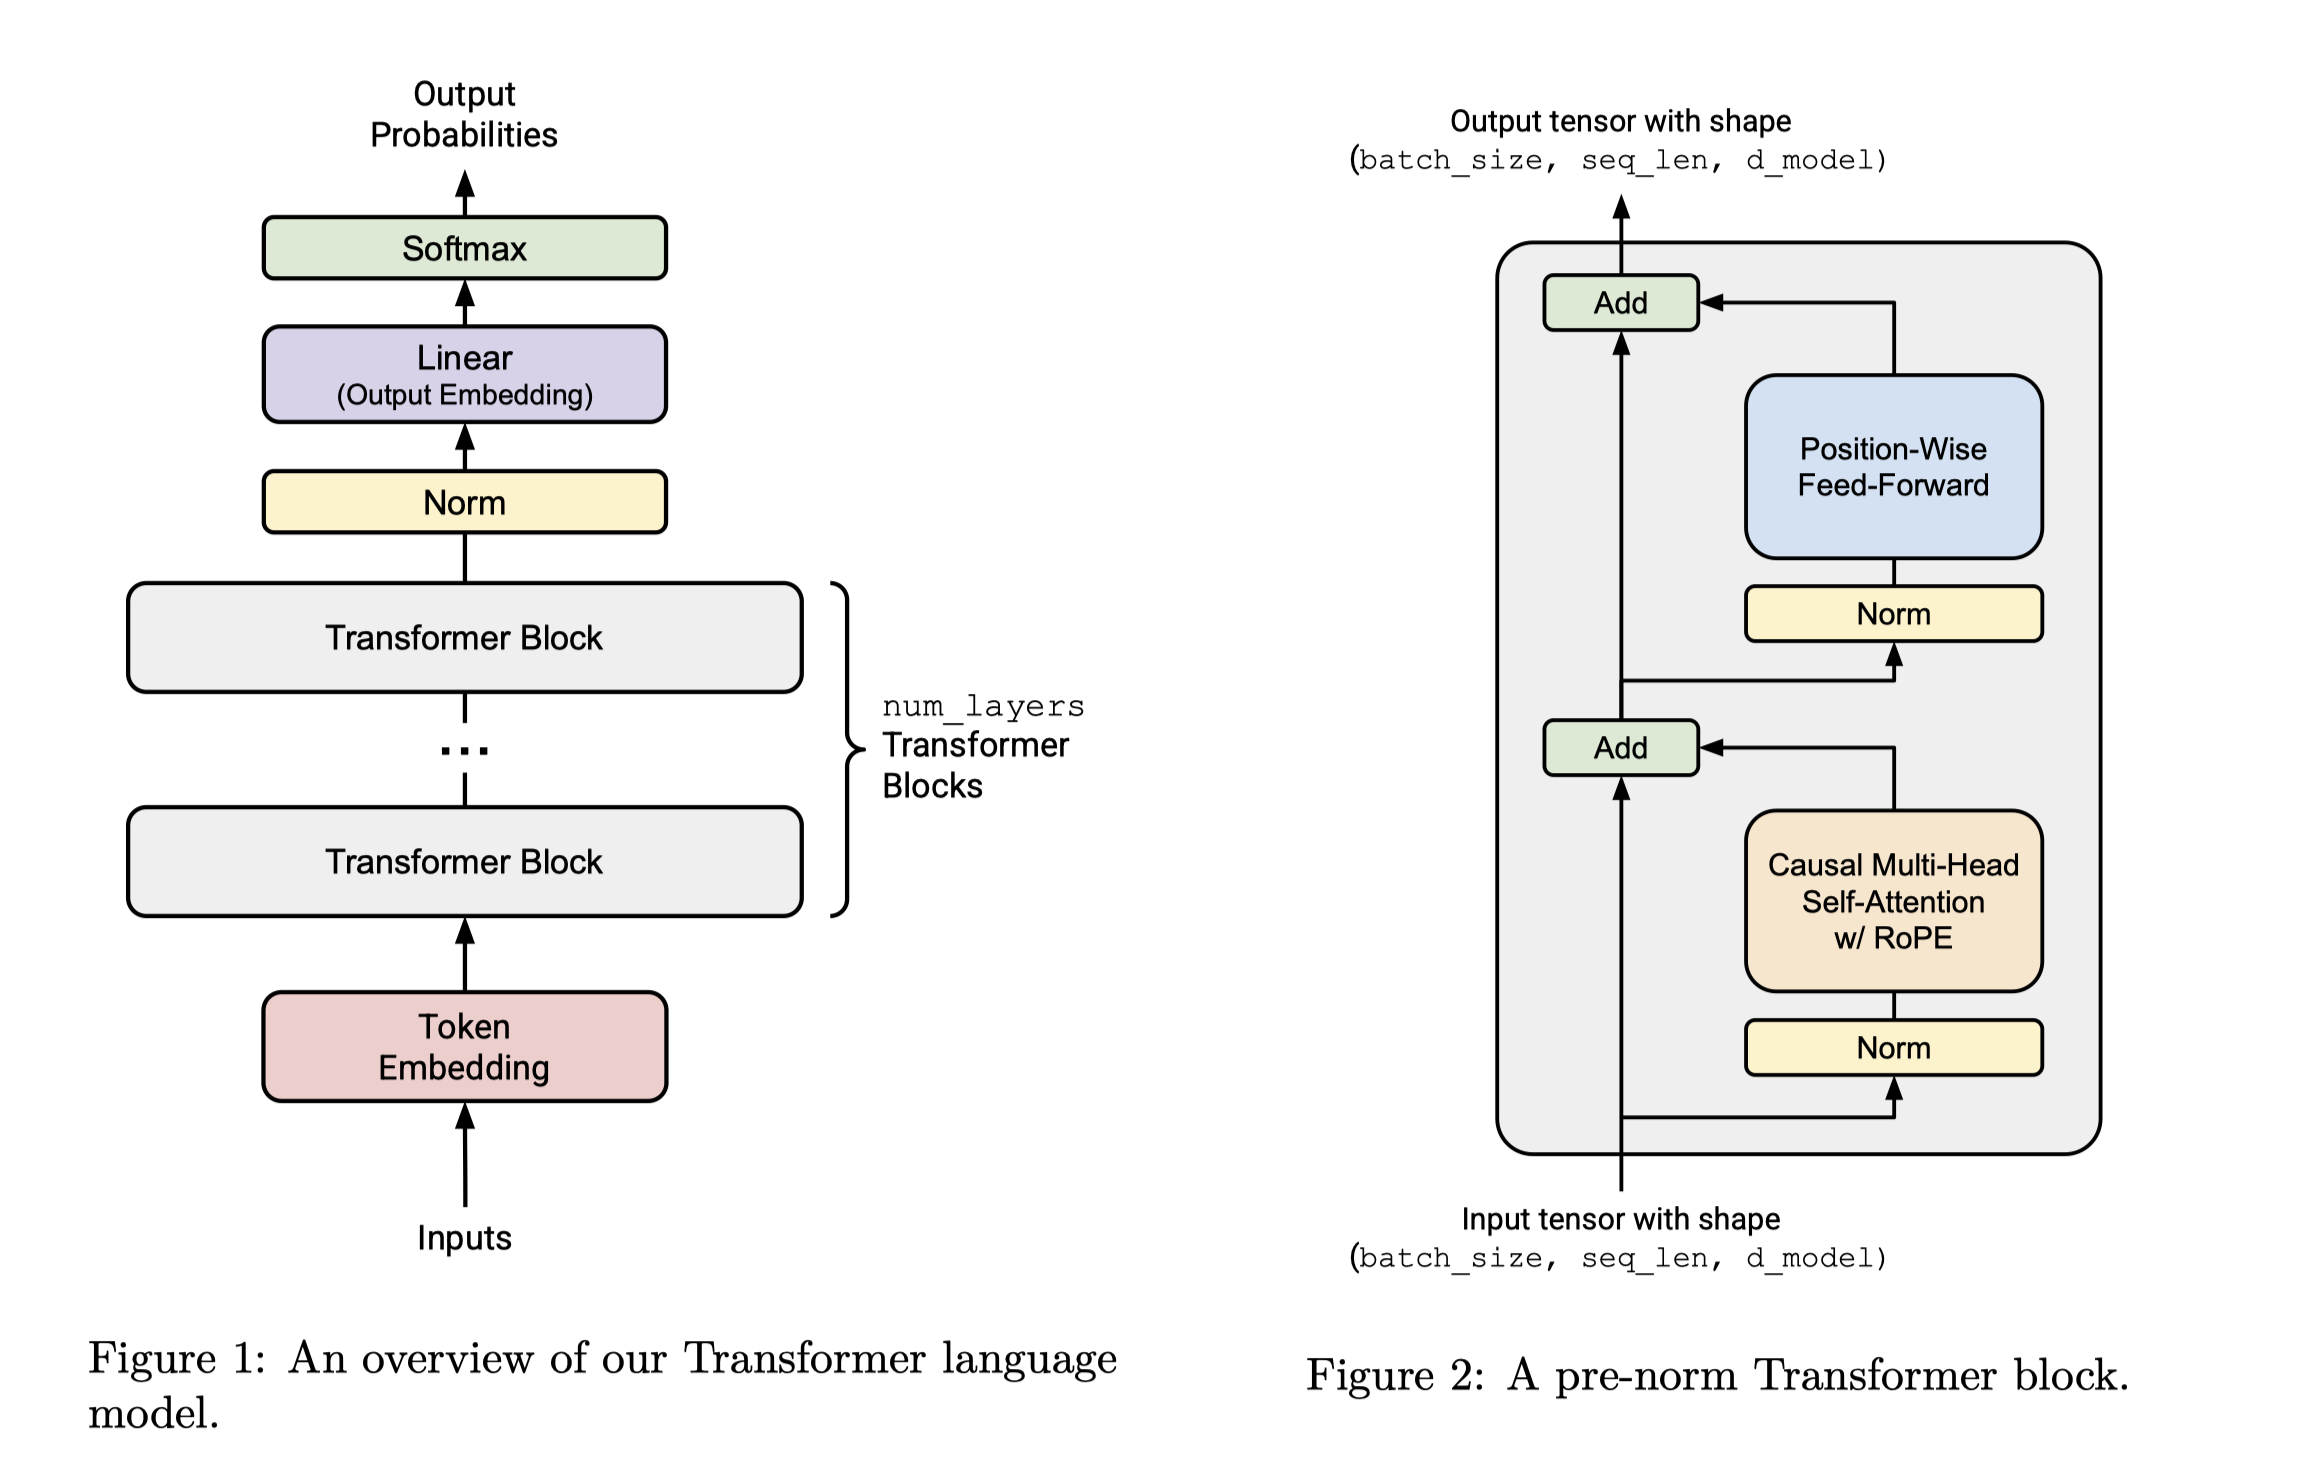

## 3.1 Einops and Einx

In [4]:
import torch 
from einops import rearrange, einsum

# Define D and A
D = torch.randn(2, 3, 4) # batch, sequence, d_in
A = torch.randn(6, 4) # d_in, d_out
## Basic implementation 
Y = D @ A.T 
# Hard to tell the input and output shapes and what they mean.

# What shapes can D and A have, and do any of these have unexpected behavior?

## Einsum is self-documenting and robust 
# # D A -> Y 
Y = einsum(D, A, "batch sequence d_in, d_out d_in -> batch sequence d_out")

## Or, a batched version where D can have any leading dimensions but A is constrained. 
Y = einsum(D, A, "... d_in, d_out d_in -> ... d_out")

In [5]:
print("D:", D)
print("A:", A)
print("Y:", Y)

D: tensor([[[-1.4878,  0.4335,  2.3819,  0.4374],
         [-0.3805,  1.3121,  0.9839, -0.6282],
         [ 0.6427, -0.8524, -0.2010,  0.9246]],

        [[ 1.0517,  0.5767,  0.8505,  1.6219],
         [ 0.6603,  1.0759,  0.1414, -1.1172],
         [ 1.6829, -0.5848,  0.8312, -2.1902]]])
A: tensor([[-1.1471, -0.8866, -0.2485,  0.4106],
        [-1.5225,  0.1470,  1.4829, -0.5333],
        [-0.4480, -0.8216, -0.0746,  2.0964],
        [ 0.0654, -0.5016,  1.7822, -1.5904],
        [ 1.5113, -1.4278, -2.0286,  0.5701],
        [-0.5261, -0.3129, -0.0519, -1.1367]])
Y: tensor([[[ 0.9100,  5.6276,  1.0496,  3.2347, -7.4501,  0.0263],
         [-1.2293,  2.5662, -2.2979,  2.0697, -4.8025,  0.4527],
         [ 0.4481, -1.8950,  2.3658, -1.3592,  3.1232, -1.1120]],

        [[-1.2631, -1.1202,  2.3917, -1.2842, -0.0347, -2.6216],
         [-2.2053, -0.0416, -3.5324,  1.5324, -1.4620,  0.5785],
         [-2.5178, -0.2474, -4.9270,  5.3680,  0.4434,  1.7441]]])


In [6]:
images = torch.randn(64, 128, 128, 3) # (batch, height, width, channel) dim_by = torch.linspace(start=0.0, end=1.0, steps=10)
dim_by = torch.linspace(start=0.0, end=1.0, steps=10)

## Reshape and multiply 
dim_value = rearrange(dim_by, "dim_value -> 1 dim_value 1 1 1") 
images_rearr = rearrange(images, "b height width channel -> b 1 height width channel") 
dimmed_images = images_rearr * dim_value

## Or in one go: 
dimmed_images = einsum(
    images, dim_by,
    "batch height width channel, dim_value -> batch dim_value height width channel" 
)

In [7]:
# print all values'shape
print("images shape:", images.shape)
print("dim_by shape:", dim_by.shape)

# print all value's shape
print("dim_value shape:", dim_value.shape)
print("images_rearr shape:", images_rearr.shape)
print("dimmed_images shape:", dimmed_images.shape)


images shape: torch.Size([64, 128, 128, 3])
dim_by shape: torch.Size([10])
dim_value shape: torch.Size([1, 10, 1, 1, 1])
images_rearr shape: torch.Size([64, 1, 128, 128, 3])
dimmed_images shape: torch.Size([64, 10, 128, 128, 3])


### Example 3 (einstein_example3): Pixel mixing with einops.rearrange

Suppose we have a batch of images represented as a tensor of shape (batch, height, width, channel), and we want to perform a linear transformation across all pixels of the image, but this transformation should happen independently for each channel. Our linear transformation is represented as a matrix B of shape (height × width, height × width).

In [8]:
channels_last = torch.randn(64, 32, 32, 3) 
B = torch.randn(32*32, 32*32)
# (batch, height, width, channel)
## Rearrange an image tensor for mixing across all pixels 
channels_last_flat = channels_last.view( -1, channels_last.size(1) * channels_last.size(2), channels_last.size(3) ) 
channels_first_flat = channels_last_flat.transpose(1, 2)
channels_first_flat_transformed = channels_first_flat @ B.T
channels_last_flat_transformed = channels_first_flat_transformed.transpose(1, 2)
channels_last_transformed = channels_last_flat_transformed.view(*channels_last.shape)


In [9]:
print(channels_last_transformed.shape)

torch.Size([64, 32, 32, 3])


In [10]:
import einx 

# Instead, using einops:

height = width = 32 ## Rearrange replaces clunky torch view + transpose 

channels_first = rearrange(
    channels_last,
    "batch height width channel -> batch channel (height width)" ) 
    
channels_first_transformed = einsum(
    channels_first, B,
    "batch channel pixel_in, pixel_out pixel_in -> batch channel pixel_out" ) 

channels_last_transformed = rearrange(
    channels_first_transformed,
    "batch channel (height width) -> batch height width channel", height=height, width=width)

# Or, if you’re feeling crazy: all in one go using einx.dot (einx equivalent of einops.einsum)
height = width = 32 
channels_last_transformed = einx.dot( 
    "batch row_in col_in channel, (row_out col_out) (row_in col_in)" "-> batch row_out col_out channel", 
    channels_last, B, col_in=width, col_out=width)

In [11]:
print("channels_first shape:", channels_first.shape)
print("channels_first_transformed shape:", channels_first_transformed.shape)
print("channels_last_transformed shape:", channels_last_transformed.shape)
print("channels_last shape:", channels_last.shape)
print("B shape:", B.shape)

channels_first shape: torch.Size([64, 3, 1024])
channels_first_transformed shape: torch.Size([64, 3, 1024])
channels_last_transformed shape: torch.Size([64, 32, 32, 3])
channels_last shape: torch.Size([64, 32, 32, 3])
B shape: torch.Size([1024, 1024])


## 3.4 Basic Building Blocks: Linear and Embedding Modules

### 3.4.2 Linear Problem (linear): Implementing the linear module

(1 point)

Deliverable: Implement a Linear class that inherits from torch.nn.Module and performs a linear transformation. Your implementation should follow the interface of PyTorch’s built-in nn.Linear module, except for not having a bias argument or parameter. We recommend the following interface:For initializations, use the settings from above along with torch.nn.init.trunc_normal_ to initialize the weights.

To test your Linear module, implement the test adapter at [adapters.run_linear]. The adapter should load the given weights into your Linear module. You can use Module.load_state_dict for this purpose. Then, run uv run pytest -k test_linear.

In [30]:
import importlib
from cs336_basics import Transformers_cs336 as my_tf
importlib.reload(my_tf)

<module 'cs336_basics.Transformers_cs336' from '/Users/ethanj/Documents/CODE/Stanford_CS336/assignment1-basics-main/cs336_basics/Transformers_cs336/__init__.py'>

To test your Linear module, implement the test adapter at [adapters.run_linear]. The adapter should load the given weights into your Linear module. You can use Module.load_state_dict for this purpose. Then, run uv run pytest -k test_linear.

In [31]:
eglinear = my_tf.modules.Linear(10, 2)
# Create a state_dict
state_dict = eglinear.state_dict()

# Modify the state_dict (for demonstration purposes)
state_dict['weight'] = torch.ones_like(state_dict['weight'])

# Load the modified state_dict back into the model
eglinear.load_state_dict(state_dict)

# Verify the loaded state
print(eglinear.state_dict()['weight'])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [24]:
state_dict

OrderedDict([('weight',
              tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
                      [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))])

### 3.4.3 Embedding Module

In [ ]:
import torch 
from torch import Tensor
import math
from einops import rearrange, einsum
from torch.nn.parameter import Parameter
from torch.nn import functional as F, init

class Embedding(torch.nn.Module):
    r"""
    Construct an embedding module.

    Args:
        num_embeddings (int): Size of the vocabulary. Each index from 0 to num_embeddings - 1 
            will have a corresponding embedding vector (i.e., vocab_size). 
        embedding_dim (int): Dimension of each embedding vector (i.e., d_model).
        device (torch.device | None, optional): The device on which to store the embedding 
            parameters. Defaults to None, which lets PyTorch choose the default device.
        dtype (torch.dtype | None, optional): The data type of the embedding parameters. 
            Defaults to None.

    Example:
        >>> emb = MyEmbedding(num_embeddings=1000, embedding_dim=512, device=torch.device("cuda"))
        >>> x = torch.tensor([1, 5, 9])
        >>> output = emb(x)  # output shape: (3, 512)
    """
    def __init__(
            self, 
            num_embeddings:int,
            embedding_dim: int,
            device:torch.device = None,
            dtype:torch.dtype = None
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__() 
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.weight = Parameter(
            torch.empty((num_embeddings, embedding_dim), **factory_kwargs)
        )
        self.reset_parameters()
    # End of the constructor

    def reset_parameters(self) -> None:
        init.trunc_normal_(
            self.weight, 
            mean = 0,
            std = 1,
            a = -3,
            b = 3
        )
    # End of the reset_parameters method

    def forward(self, token_ids: Tensor) -> Tensor:
        # test for the class structures
        # return F.embedding(token_ids, self.weight)
        return self.weight[token_ids]
    

### 3.5.3 Relative Positional Embeddings

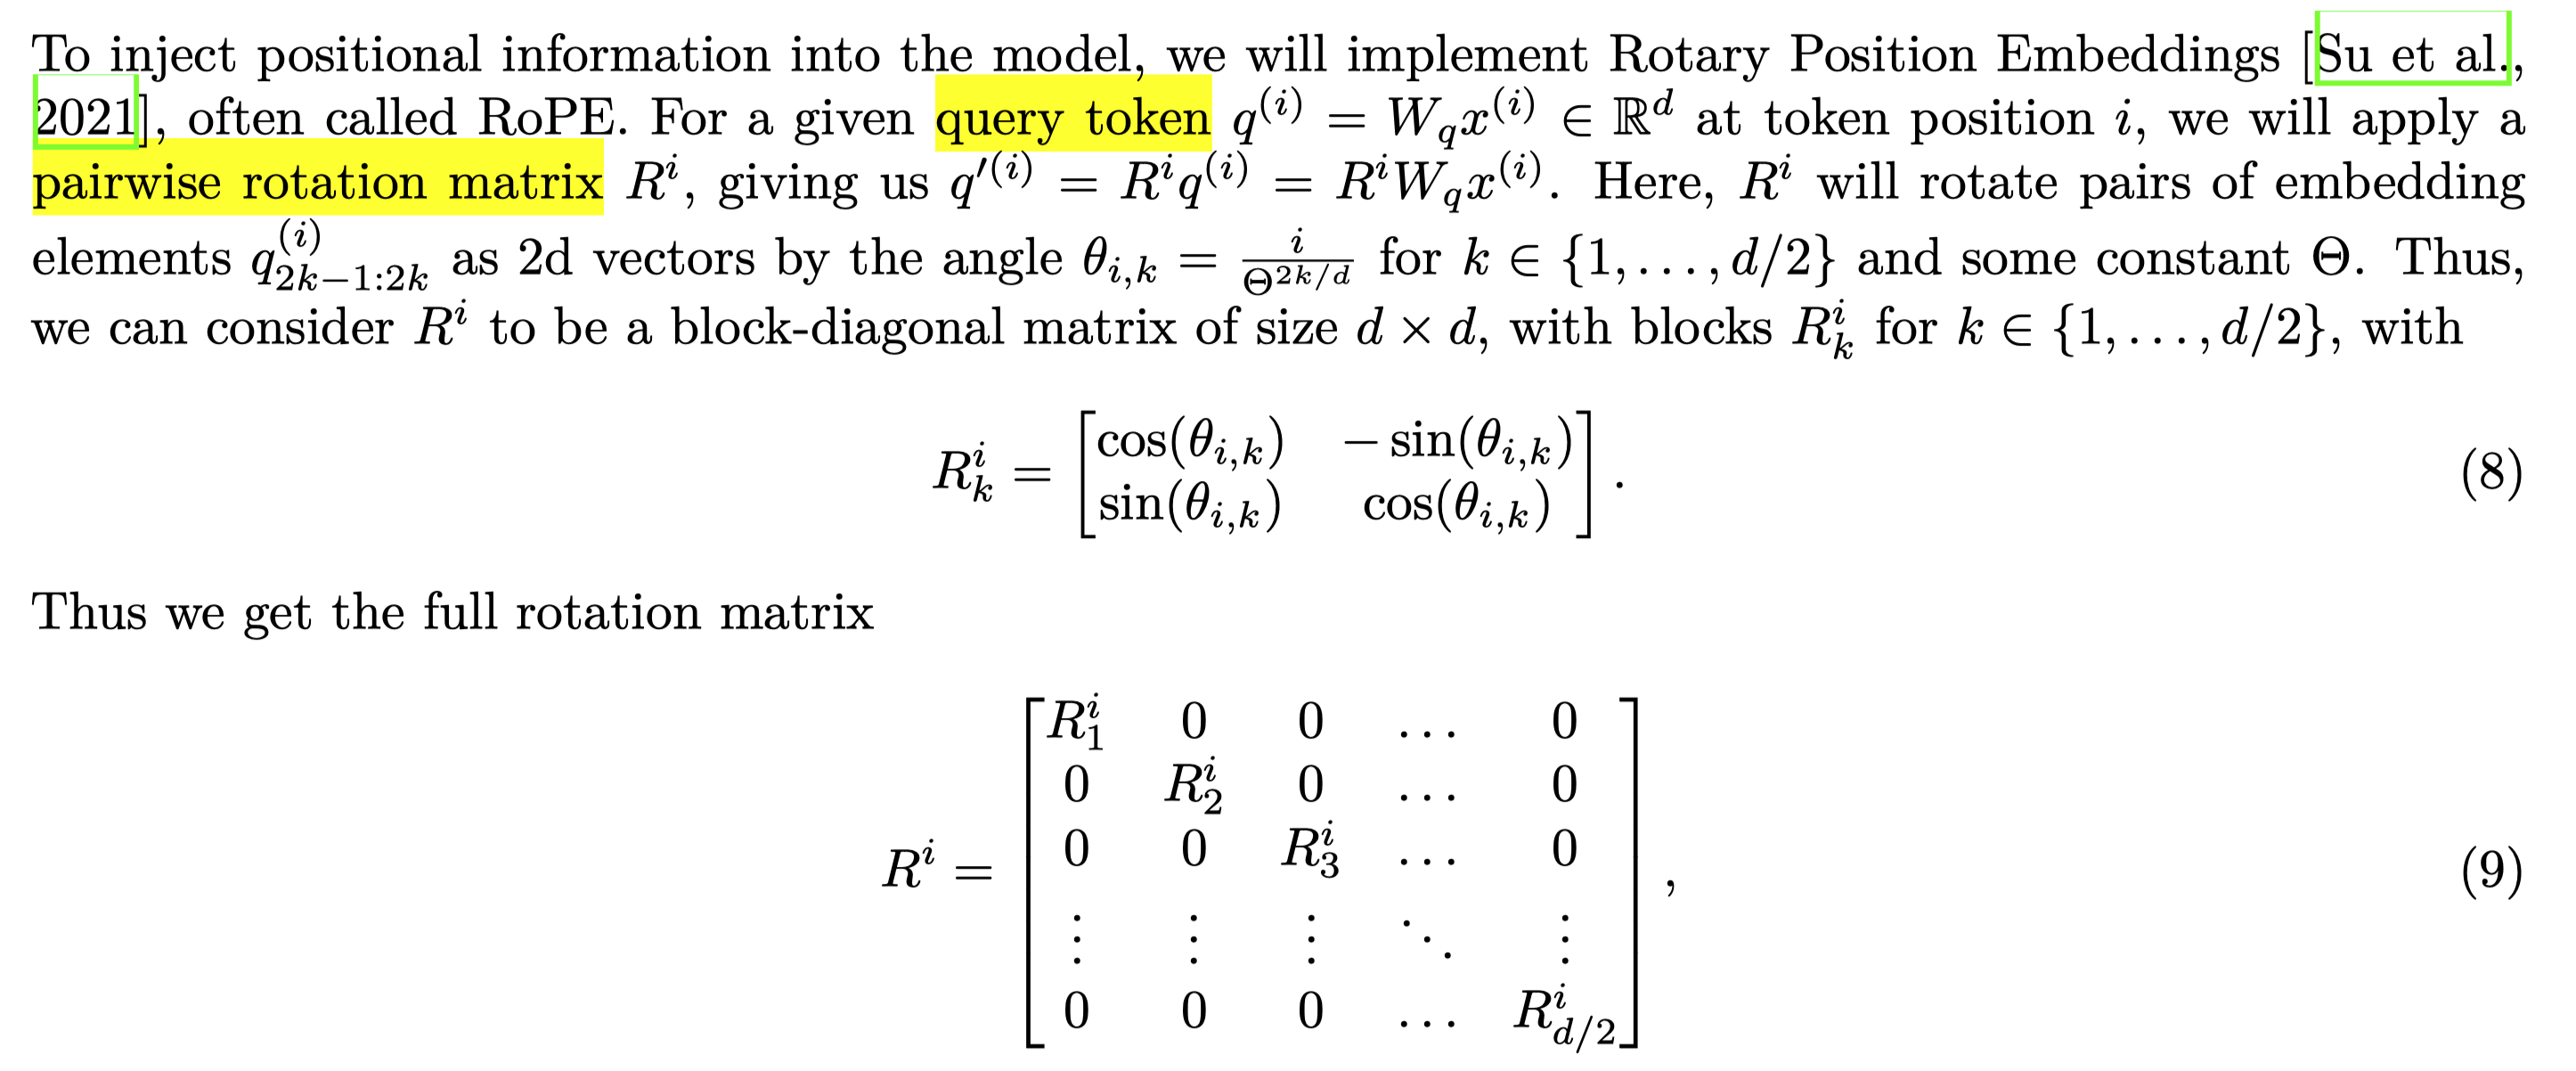

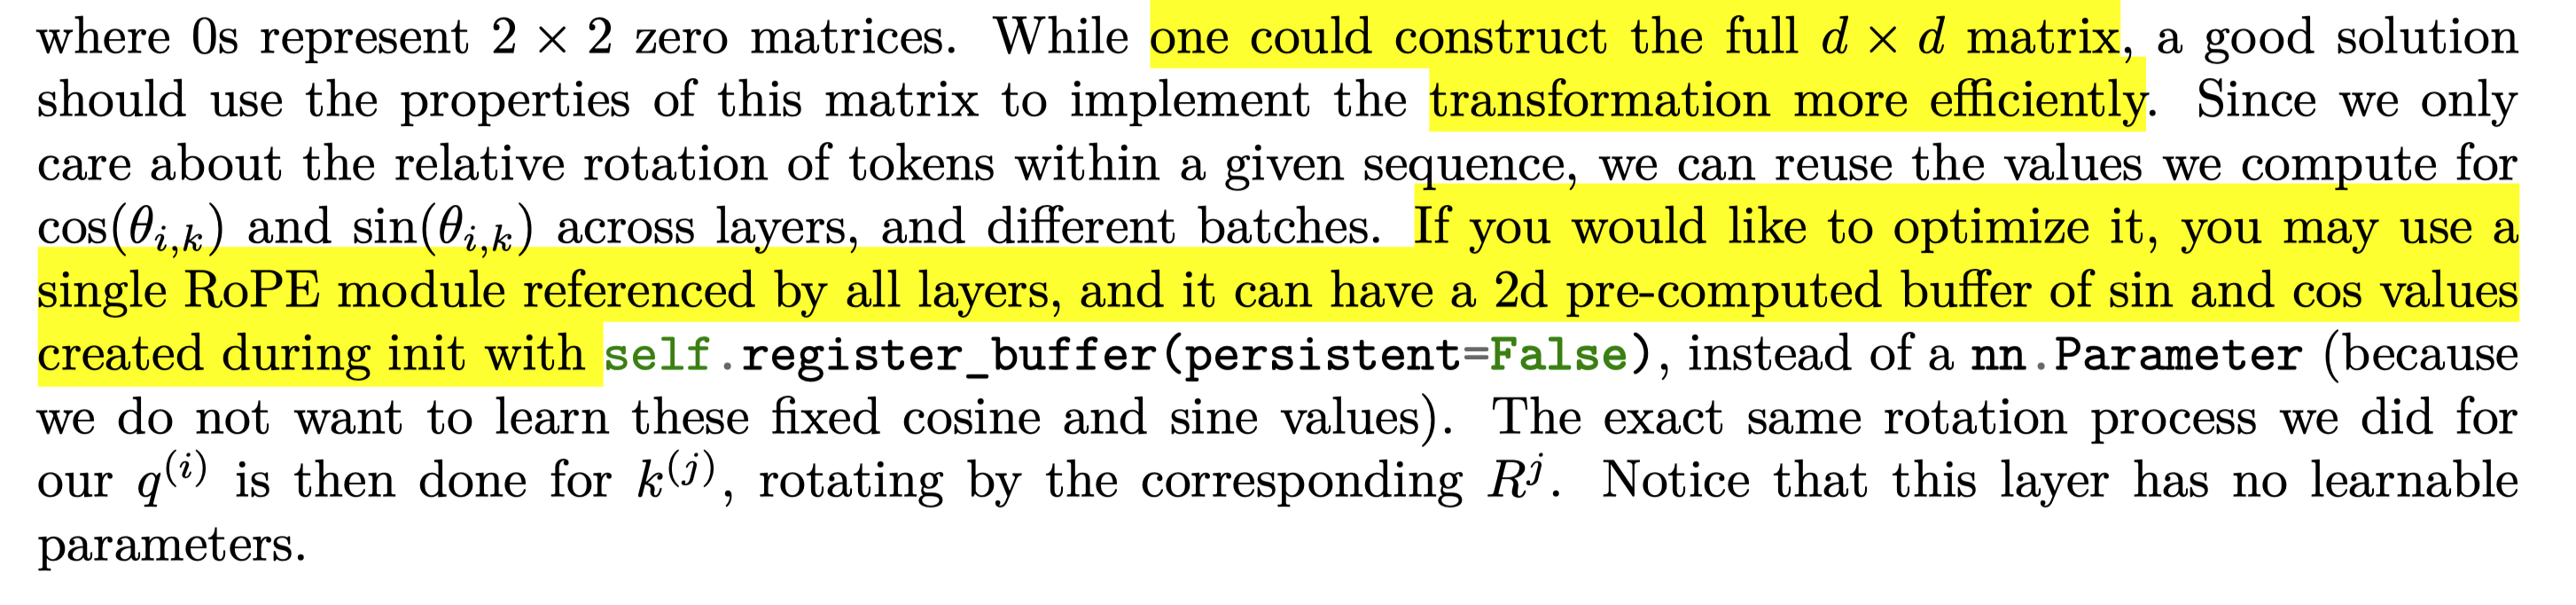

In [86]:
import math
theta: float = 10000.0
d_k: int = 64   
max_seq_len:int = 12
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

i = 1
k = 1

In [264]:
# Create the whole R matrix
R = torch.empty((max_seq_len, int(d_k/2), 2, 2))

for i in range(max_seq_len):
    for k in range(int(d_k / 2)):
        angle_theta = i / (math.pow(theta, (2.0 * k / d_k)))
        cos_theata = math.cos(angle_theta)
        sin_theta = math.sin(angle_theta)

        R_i_k = torch.tensor([
            [cos_theata, -sin_theta],
            [sin_theta, cos_theata]
        ], device=device)
        R[i, k, :, :] = R_i_k

def forward(self, x: torch.Tensor, token_positions: torch.Tensor) -> torch.Tensor 


Process an input tensor of shape (..., seq_len, d_k) and return a tensor of the same shape. 


Note that you should tolerate x with an arbitrary number of batch dimensions. 


You should assume that the token positions are a tensor of shape (..., seq_len) specifying the token positions of x along the sequence dimension.


You should use the token positions to slice your (possibly precomputed) cos and sin tensors along the sequence dimension.

In [237]:
R.shape

torch.Size([12, 32, 2, 2])

In [257]:
from einops import rearrange, einsum, reduce
token_positions = torch.arange(0, max_seq_len)
torch.manual_seed(4)
x = torch.randn(4, max_seq_len, d_k)

In [ ]:
# Precompute angle frequencies
inv_freq = 1.0 / (theta ** (torch.arange(0, d_k, 2).float() / d_k))  # (d_k // 2,)
pos = torch.arange(max_seq_len, dtype=torch.float32)  # (max_seq_len,)
angles = torch.einsum("i,j->ij", pos, inv_freq)  # (max_seq_len, d_k // 2)

# Store cos/sin for all positions and dimensions
cos_buffer = torch.cos(angles)
sin_buffer = torch.sin(angles)

cos = cos_buffer[token_positions]  # (..., seq_len, d_k // 2)
sin = sin_buffer[token_positions]  # (..., seq_len, d_k // 2)

# Split x into even/odd channels: x[..., 0::2], x[..., 1::2]
x = rearrange(x, "... seq (d r) -> ... seq d r", r=2)  # (..., seq_len, d_k//2, 2)
x_even = x[..., 0]  # (..., seq_len, d_k//2)
x_odd  = x[..., 1]  # (..., seq_len, d_k//2)

# Apply RoPE rotation
rotated_even = x_even * cos - x_odd * sin
rotated_odd  = x_even * sin + x_odd * cos

# Step 2: Build R matrix (max_seq_len, d_k // 2, 2, 2)
R_angle = torch.stack([
    torch.stack([cos, -sin], dim=-1),  # (..., 2)
    torch.stack([sin,  cos], dim=-1),  # (..., 2)
], dim=-2)  # shape: (max_seq_len, d_k // 2, 2, 2)


# Combine back into (..., seq_len, d_k)
out = rearrange([rotated_even, rotated_odd], "r ... seq d -> ... seq (d r)")

In [268]:
R = torch.empty((max_seq_len, d_k // 2, 2, 2), dtype=torch.float32)

for i in range(max_seq_len):
    for k in range(d_k // 2):
        angle_theta = i / (theta ** (2.0 * k / d_k))
        cos_theta = math.cos(angle_theta)
        sin_theta = math.sin(angle_theta)

        R[i, k, 0, 0] = cos_theta
        R[i, k, 0, 1] = -sin_theta
        R[i, k, 1, 0] = sin_theta
        R[i, k, 1, 1] = cos_theta

In [269]:
R == R_angle

tensor([[[[ True,  True],
          [ True,  True]],

         [[ True,  True],
          [ True,  True]],

         [[ True,  True],
          [ True,  True]],

         ...,

         [[ True,  True],
          [ True,  True]],

         [[ True,  True],
          [ True,  True]],

         [[ True,  True],
          [ True,  True]]],


        [[[False,  True],
          [ True, False]],

         [[ True,  True],
          [ True,  True]],

         [[ True,  True],
          [ True,  True]],

         ...,

         [[ True, False],
          [False,  True]],

         [[ True,  True],
          [ True,  True]],

         [[ True, False],
          [False,  True]]],


        [[[ True,  True],
          [ True,  True]],

         [[False,  True],
          [ True, False]],

         [[ True,  True],
          [ True,  True]],

         ...,

         [[ True, False],
          [False,  True]],

         [[ True,  True],
          [ True,  True]],

         [[False, False],
       

In [255]:
re_in_query_or_key = rearrange(in_query_or_key, "batch pos (b1 b2) -> batch pos b1 b2", b2 = 2)

In [241]:
re_in_query_or_key.shape

torch.Size([4, 12, 32, 2])

In [242]:
rotated = einsum(
    re_in_query_or_key, R,
    "... pos b1 b2, pos b1 b2 b3 -> ... pos b1 b2",
)

In [228]:
rotated.shape

torch.Size([4, 12, 32, 2])

In [243]:
put_it_back = rearrange(rotated, "batch pos b1 b2 -> batch pos (b1 b2)")
put_it_back.shape

torch.Size([4, 12, 64])

In [246]:
out[0]

tensor([[-9.4142e-01,  1.2632e+00, -1.8377e-01,  1.5051e-01,  1.0750e-01,
         -2.7803e-01, -2.6021e+00,  6.2446e-01, -8.6836e-01, -2.0506e-01,
          3.9756e-01,  6.6993e-01, -5.3707e-02,  4.6695e-02, -1.7671e+00,
         -2.1205e+00,  1.5191e+00, -6.6820e-01,  3.0777e-03, -1.5355e-01,
          1.1396e+00, -2.3019e-01,  1.1877e+00,  7.6774e-01, -7.5883e-01,
         -1.8534e-01, -8.5579e-01, -2.3464e-01, -4.2153e-01,  8.4884e-01,
         -6.7758e-01, -9.4454e-01, -4.8154e-01,  1.2434e+00,  2.3693e+00,
          2.8294e-01, -2.3454e-01,  1.6892e+00,  2.7164e-01, -1.3655e-01,
         -6.9479e-01, -1.3186e+00, -9.6939e-01,  6.4025e-01,  8.2012e-01,
         -9.1511e-01, -2.1437e+00,  1.4072e+00, -2.6317e-02,  2.7204e+00,
         -5.9554e-01,  9.8715e-01,  1.0861e+00,  6.0981e-02,  4.1661e-02,
          6.7826e-01, -8.9515e-01, -1.0143e+00, -2.4286e-01, -1.5727e+00,
          1.3940e+00, -1.9406e-01,  4.8184e-03, -1.3165e+00],
        [ 1.5003e-01, -7.2087e-02, -1.9782e-01,  5

In [247]:
 put_it_back[0]

tensor([[-9.4142e-01,  1.2632e+00, -1.8377e-01,  1.5051e-01,  1.0750e-01,
         -2.7803e-01, -2.6021e+00,  6.2446e-01, -8.6836e-01, -2.0506e-01,
          3.9756e-01,  6.6993e-01, -5.3707e-02,  4.6695e-02, -1.7671e+00,
         -2.1205e+00,  1.5191e+00, -6.6820e-01,  3.0777e-03, -1.5355e-01,
          1.1396e+00, -2.3019e-01,  1.1877e+00,  7.6774e-01, -7.5883e-01,
         -1.8534e-01, -8.5579e-01, -2.3464e-01, -4.2153e-01,  8.4884e-01,
         -6.7758e-01, -9.4454e-01, -4.8154e-01,  1.2434e+00,  2.3693e+00,
          2.8294e-01, -2.3454e-01,  1.6892e+00,  2.7164e-01, -1.3655e-01,
         -6.9479e-01, -1.3186e+00, -9.6939e-01,  6.4025e-01,  8.2012e-01,
         -9.1511e-01, -2.1437e+00,  1.4072e+00, -2.6317e-02,  2.7204e+00,
         -5.9554e-01,  9.8715e-01,  1.0861e+00,  6.0981e-02,  4.1661e-02,
          6.7826e-01, -8.9515e-01, -1.0143e+00, -2.4286e-01, -1.5727e+00,
          1.3940e+00, -1.9406e-01,  4.8184e-03, -1.3165e+00],
        [-6.1442e-03, -2.2826e-01,  1.0589e-02,  7

In [250]:
out[2].shape

torch.Size([12, 64])

In [251]:
out[2] - put_it_back[2]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.2870e+00,  1.2870e+00, -2.3551e+00, -2